# Анализ оттока клиентов

Эта тетрадь шаг за шагом исследует датасет Advanced DLS Telecom Churn и строит базовые модели классификации оттока.
- **Цель:** предсказать признак `Churn` и понять драйверы ухода клиентов.
- **Источник:** соревнование Kaggle `advanced-dls-spring-2021`.
- **Подход:** разведочный анализ → подготовка признаков → обучение/валидация моделей → экспорт предсказаний.


## Оглавление
1. [Подготовка окружения](#1-setup--imports)
2. [Загрузка данных](#2-data-loading)
3. [Первичный аудит](#3-initial-data-audit)
4. [Баланс целевого признака](#4-target-balance)
5. [Числовые признаки](#5-numerical-feature-analysis)
6. [Корреляции](#6-correlation-structure)
7. [Категориальные драйверы](#7-categorical-drivers)
8. [Подготовка и кодирование](#8-preprocessing--encoding)
9. [Сплит и масштабирование](#9-trainvalidation-split--scaling)
10. [Обучение моделей](#10-model-training)
11. [Сравнение и диагностика](#11-model-comparison--diagnostics)
12. [Предсказания и сабмишен](#12-predictions--submission)


<a id="1-setup--imports"></a>
## 1. Подготовка окружения
Импортирую библиотеки для анализа, визуализаций и классических моделей, задаю единый стиль графиков и отключаю лишние предупреждения.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

<a id="2-data-loading"></a>
## 2. Загрузка данных
Читаю Kaggle-файлы train/test, фиксирую размер выборок и просматриваю первые строки для быстрой ручной проверки структуры.


In [2]:
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nПервые строки train:")
train.head()

Train shape: (5282, 20)
Test shape: (1761, 19)

Первые строки train:


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<a id="3-initial-data-audit"></a>
## 3. Первичный аудит
С помощью `info()` и `describe()` определяю типы признаков, диапазоны значений и общее состояние целевой переменной перед углублённым анализом.


In [3]:
print("=== Информация о данных ===")
print(train.info())
print("\n=== Статистика числовых фич ===")
train.describe()

=== Информация о данных ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


### Срез пропусков
Подсчитываю количество `NaN` по столбцам в train/test, чтобы заранее понимать, какие признаки требуют очистки.


In [4]:
print("=== Пропуски в train ===")
print(train.isnull().sum())
print("\n=== Пропуски в test ===")
print(test.isnull().sum())

=== Пропуски в train ===
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

=== Пропуски в test ===
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnli

<a id="4-target-balance"></a>
## 4. Баланс целевого признака
Строю диаграммы распределения классов Churn (количества и доли), оцениваю дисбаланс и соотношение, чтобы скорректировать подход к обучению.


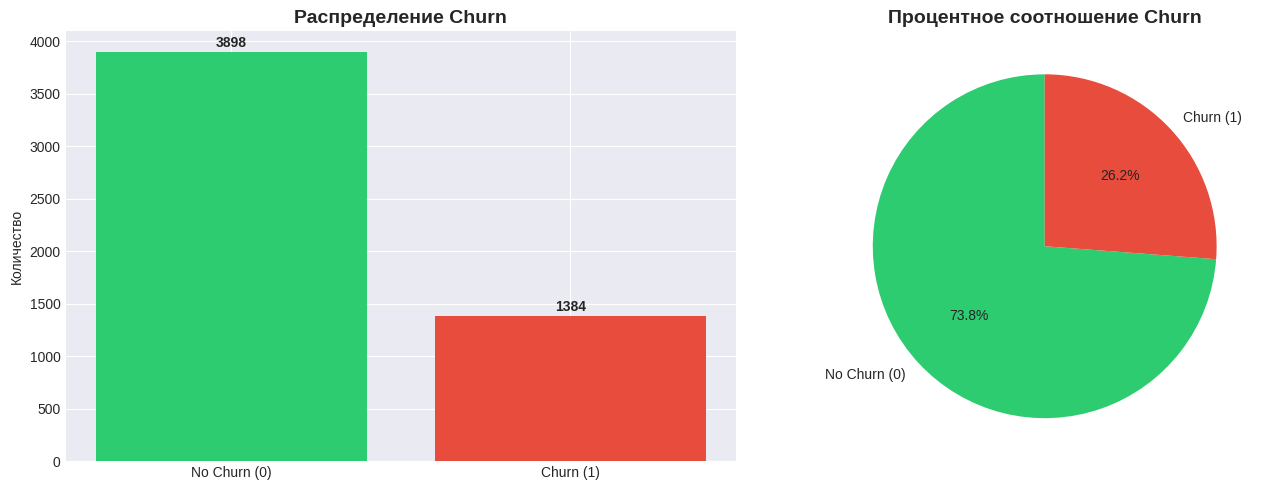


Класс 0 (No Churn): 3898 (73.80%)
Класс 1 (Churn): 1384 (26.20%)
Соотношение: 1:2.82


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

churn_counts = train['Churn'].value_counts()
axes[0].bar(['No Churn (0)', 'Churn (1)'], churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Распределение Churn', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

churn_pct = train['Churn'].value_counts(normalize=True) * 100
axes[1].pie(churn_pct.values, labels=['No Churn (0)', 'Churn (1)'], 
            autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Процентное соотношение Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nКласс 0 (No Churn): {churn_counts[0]} ({churn_pct[0]:.2f}%)")
print(f"Класс 1 (Churn): {churn_counts[1]} ({churn_pct[1]:.2f}%)")
print(f"Соотношение: 1:{churn_counts[0]/churn_counts[1]:.2f}")

<a id="5-numerical-feature-analysis"></a>
## 5. Анализ числовых признаков
Перевожу `TotalSpent` в числовой тип, изучаю гистограммы и boxplot ключевых числовых фич, сравнивая распределения для Churn=0/1 и средние значения.


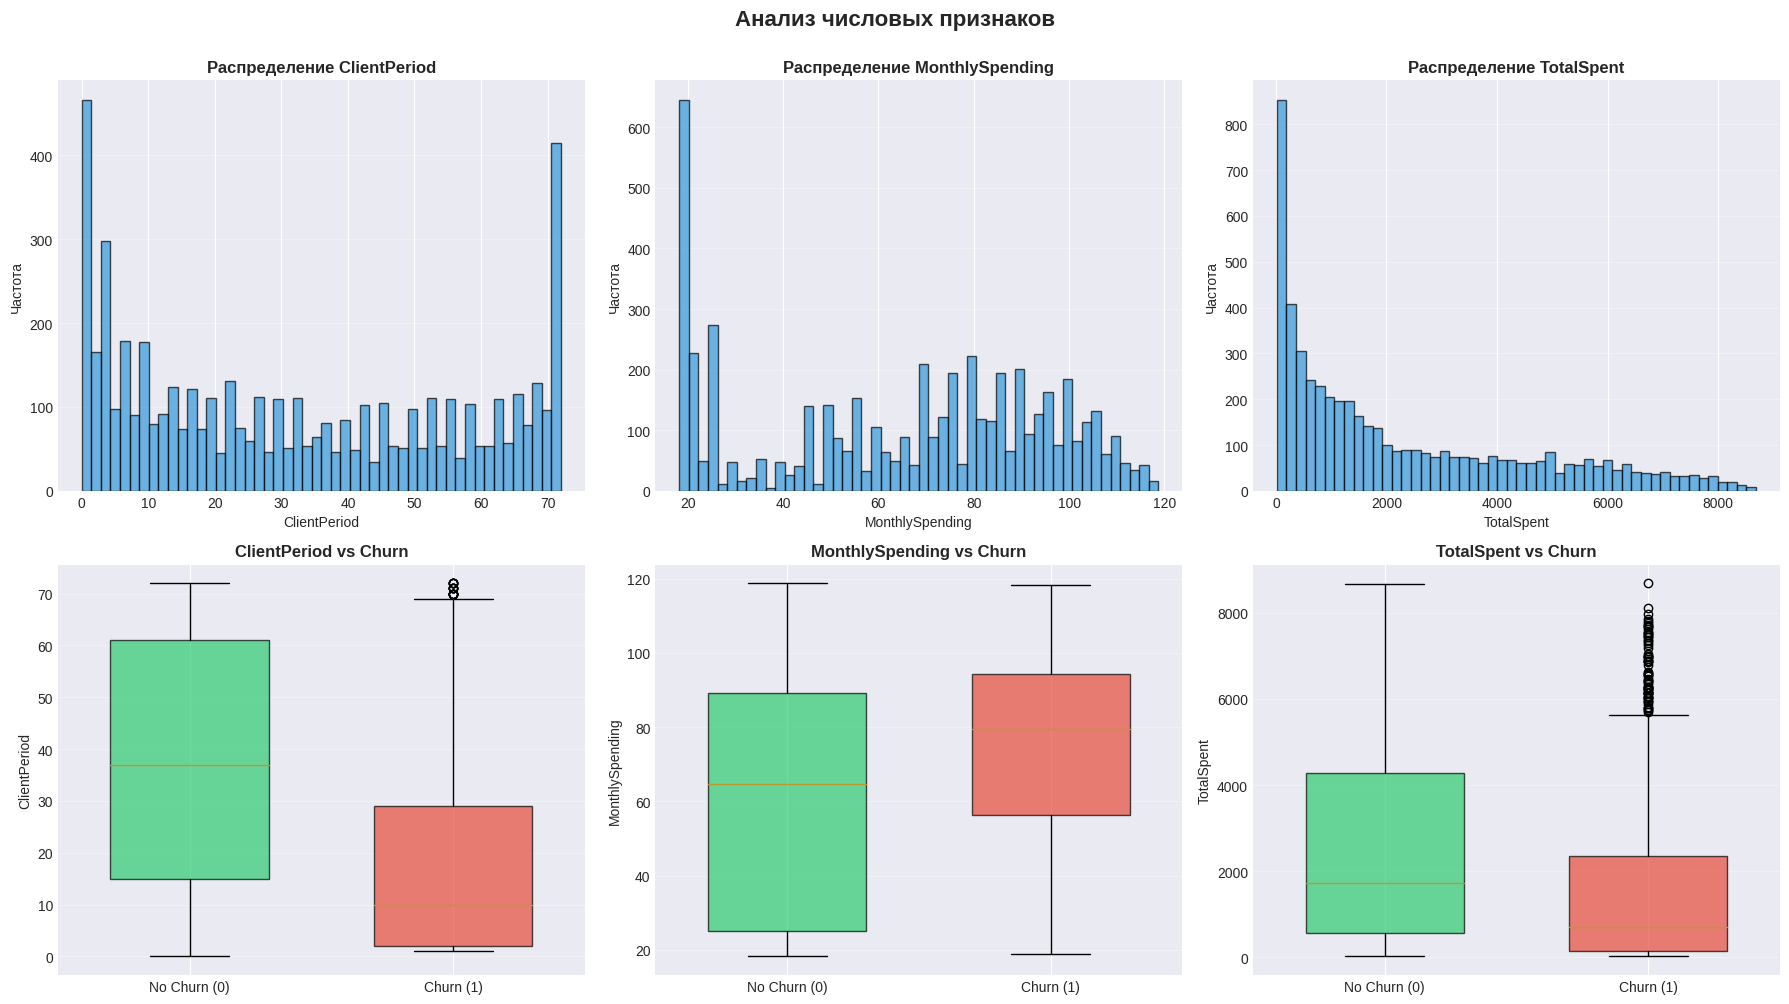


=== Статистика по группам Churn ===
       ClientPeriod  MonthlySpending   TotalSpent
Churn                                            
0         37.525911        61.602719  2563.834045
1         17.951590        74.281178  1525.831864


In [6]:
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')

numeric_features = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, feature in enumerate(numeric_features):
    axes[0, idx].hist(train[feature].dropna(), bins=50, edgecolor='black', alpha=0.7, color='#3498db')
    axes[0, idx].set_title(f'Распределение {feature}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel(feature)
    axes[0, idx].set_ylabel('Частота')
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    churn_0 = train[train['Churn'] == 0][feature].dropna()
    churn_1 = train[train['Churn'] == 1][feature].dropna()
    
    bp = axes[1, idx].boxplot([churn_0, churn_1], labels=['No Churn (0)', 'Churn (1)'],
                               patch_artist=True, widths=0.6)
    
    for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[1, idx].set_title(f'{feature} vs Churn', fontsize=12, fontweight='bold')
    axes[1, idx].set_ylabel(feature)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Анализ числовых признаков', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n=== Статистика по группам Churn ===")
print(train.groupby('Churn')[numeric_features].mean())

<a id="6-correlation-structure"></a>
## 6. Корреляционная структура
Строю тепловую карту корреляций числовых признаков и отдельно ранжирую связь каждого признака с `Churn`, чтобы выявить потенциально сильные сигналы.


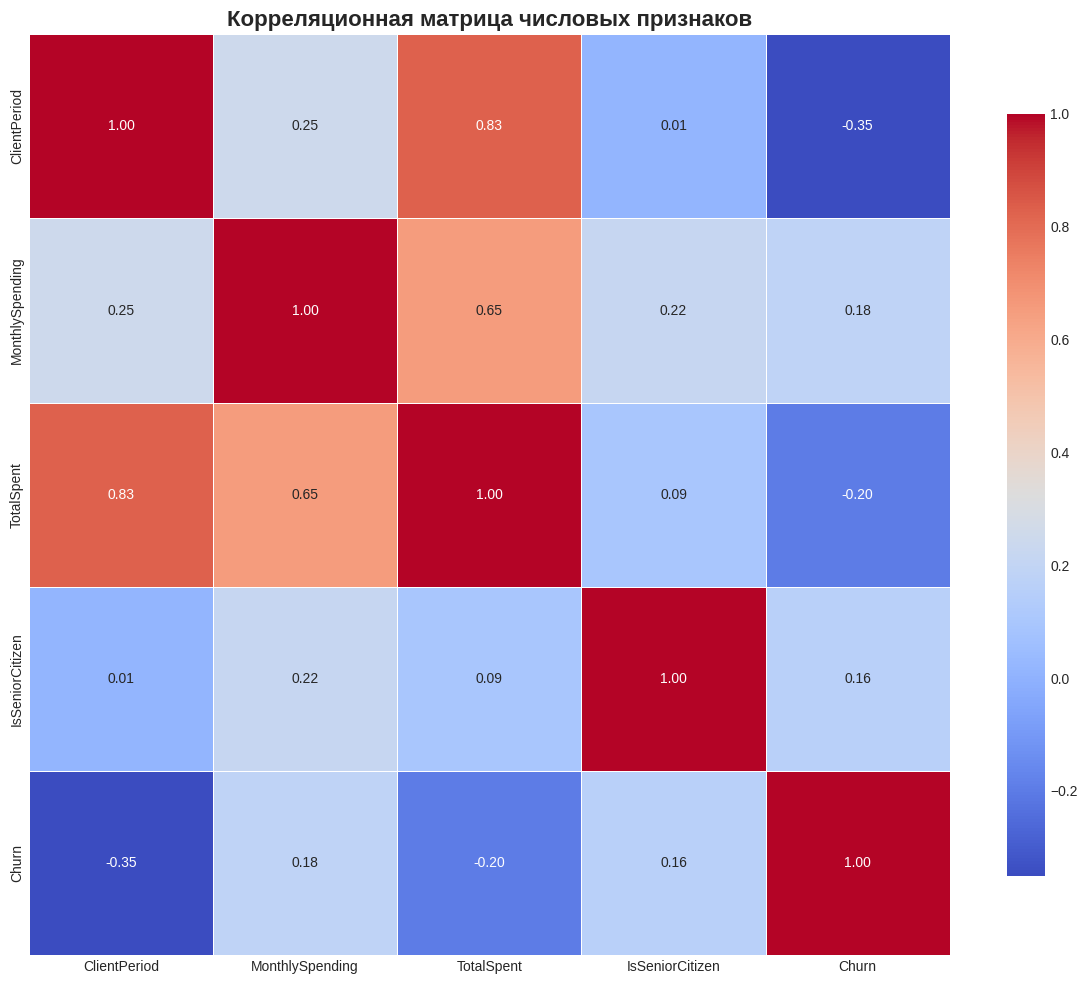


=== Корреляция признаков с Churn ===
Churn              1.000000
MonthlySpending    0.184769
IsSeniorCitizen    0.156872
TotalSpent        -0.201294
ClientPeriod      -0.350640
Name: Churn, dtype: float64


In [7]:
train_numeric = train.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation = train_numeric.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица числовых признаков', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Корреляция признаков с Churn ===")
print(correlation['Churn'].sort_values(ascending=False))

<a id="7-categorical-drivers"></a>
## 7. Категориальные драйверы
Для категориальных признаков считаю средний churn rate по каждому значению и визуализирую горизонтальными барами, подчеркивая рискованные сегменты.


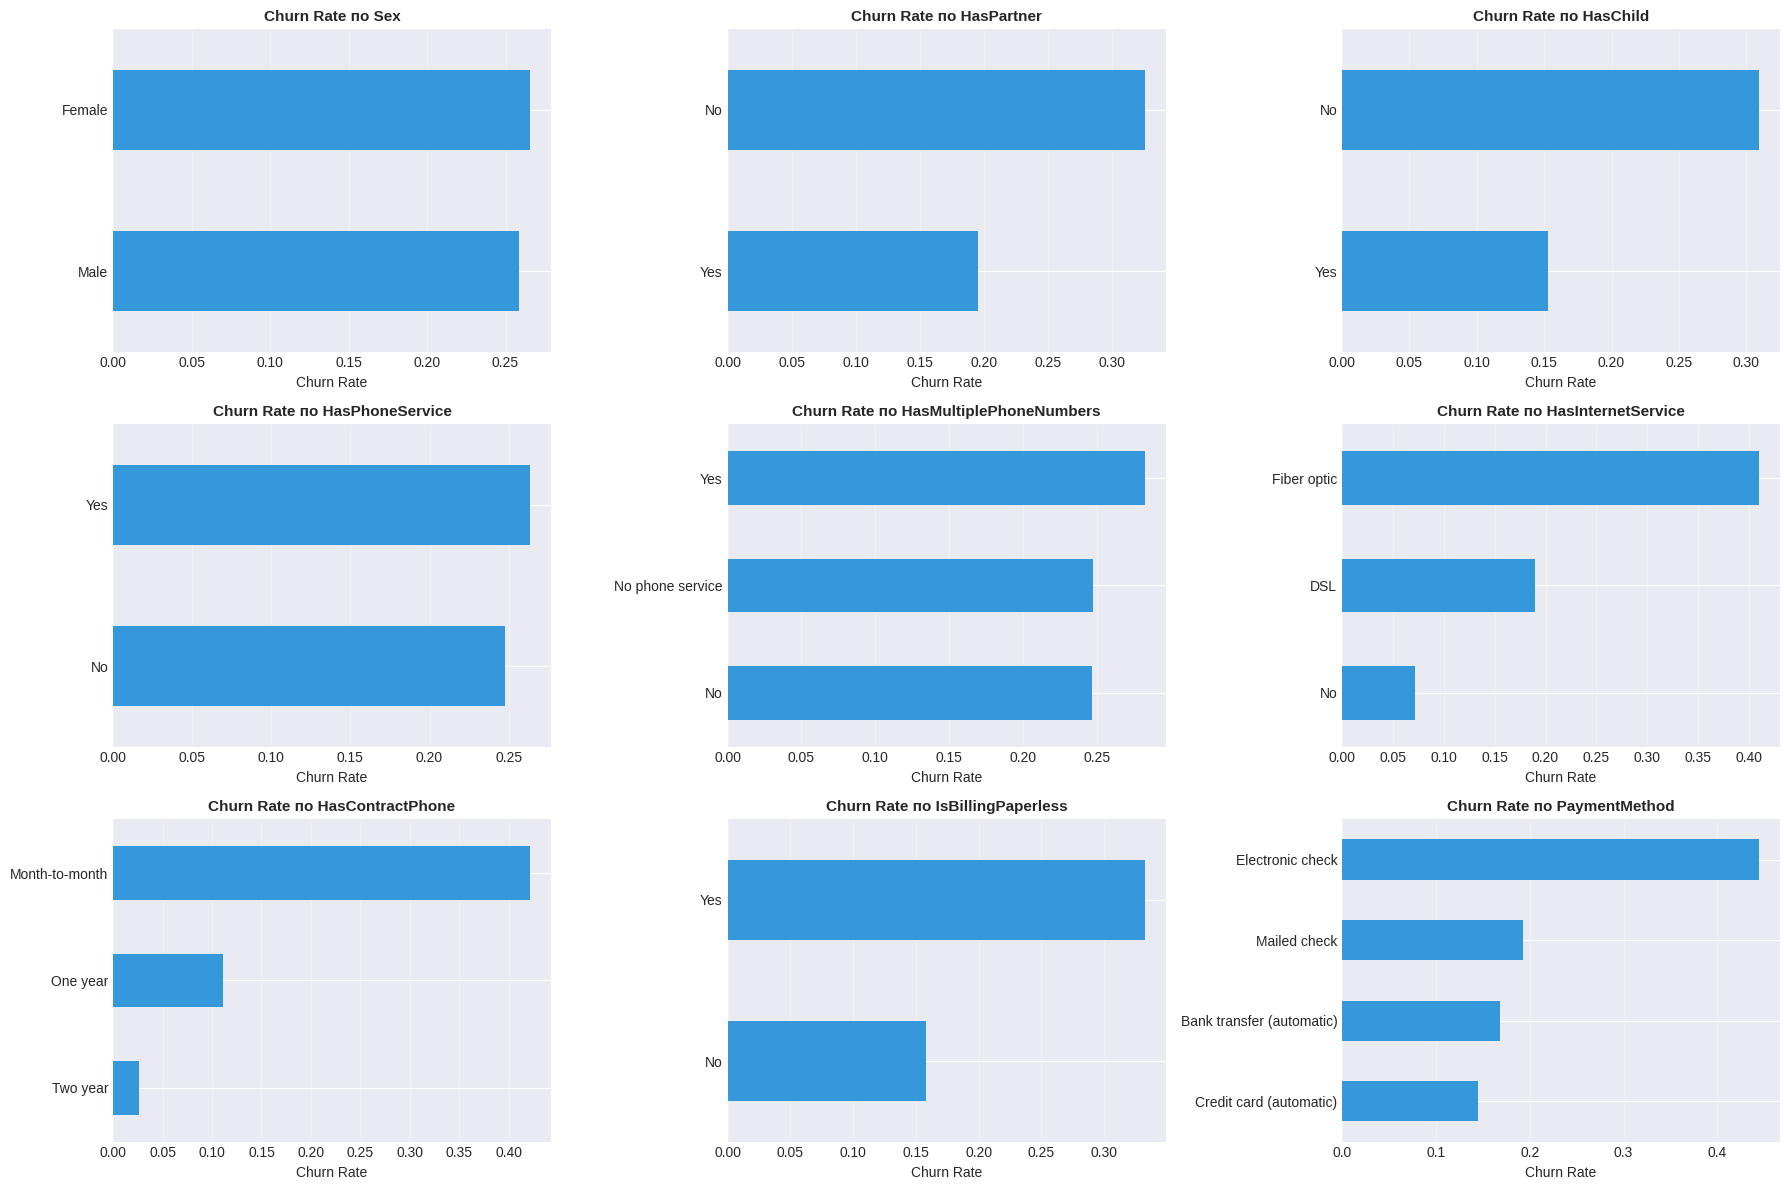

In [8]:
categorical_features = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 
                        'HasMultiplePhoneNumbers', 'HasInternetService', 
                        'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    churn_rates = train.groupby(feature)['Churn'].mean().sort_values()
    churn_rates.plot(kind='barh', ax=axes[idx], color='#3498db')
    axes[idx].set_title(f'Churn Rate по {feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Churn Rate')
    axes[idx].set_ylabel('')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

<a id="8-preprocessing--encoding"></a>
## 8. Подготовка данных и кодирование
Создаю копии датасетов, закрываю пропуски медианой и кодирую категориальные признаки через `LabelEncoder`, контролируя отсутствие оставшихся `NaN`.


In [9]:
train_processed = train.copy()
test_processed = test.copy()

train_processed['TotalSpent'] = pd.to_numeric(train_processed['TotalSpent'], errors='coerce')
test_processed['TotalSpent'] = pd.to_numeric(test_processed['TotalSpent'], errors='coerce')

print("=== Проверка пропусков после конвертации ===")
print(f"Train NaN in TotalSpent: {train_processed['TotalSpent'].isnull().sum()}")
print(f"Test NaN in TotalSpent: {test_processed['TotalSpent'].isnull().sum()}")

train_processed['TotalSpent'].fillna(train_processed['TotalSpent'].median(), inplace=True)
test_processed['TotalSpent'].fillna(train_processed['TotalSpent'].median(), inplace=True)

label_encoders = {}
categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train_processed[col], test_processed[col]])
    le.fit(combined)
    train_processed[col] = le.transform(train_processed[col])
    test_processed[col] = le.transform(test_processed[col])
    label_encoders[col] = le

print(f"\nКатегориальные признаки закодированы: {len(categorical_cols)} колонок")
print("\n=== Финальная проверка пропусков ===")
print(f"Train: {train_processed.isnull().sum().sum()} пропусков")
print(f"Test: {test_processed.isnull().sum().sum()} пропусков")

train_processed.head()

=== Проверка пропусков после конвертации ===
Train NaN in TotalSpent: 9
Test NaN in TotalSpent: 2

Категориальные признаки закодированы: 15 колонок

=== Финальная проверка пропусков ===
Train: 0 пропусков
Test: 0 пропусков


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,1,0,1,1,1,0,2,1,1,1,1,1,1,1,0,3,0
1,72,25.85,1872.20,1,0,1,0,1,2,2,1,1,1,1,1,1,2,0,1,0
2,1,75.90,75.90,1,0,0,0,1,0,1,0,0,0,2,0,0,0,1,2,1
3,32,79.30,2570.00,0,1,1,0,1,2,1,0,0,2,0,0,0,0,0,3,0
4,60,115.25,6758.45,0,0,1,1,1,2,1,2,2,2,2,2,2,2,0,1,0


<a id="9-trainvalidation-split--scaling"></a>
## 9. Сплит и масштабирование
Разделяю выборку на train/validation со стратификацией по `Churn`, проверяю размеры и баланс классов перед масштабированием признаков.


In [10]:
X = train_processed.drop('Churn', axis=1)
y = train_processed['Churn']

print(f"Проверка NaN в X: {X.isnull().sum().sum()}")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"\nРаспределение в train: {np.bincount(y_train)}")
print(f"Распределение в val: {np.bincount(y_val)}")

Проверка NaN в X: 0

Train set: 4225 samples
Validation set: 1057 samples

Распределение в train: [3118 1107]
Распределение в val: [780 277]


### Контроль масштабирования
Применяю `StandardScaler` к train/val/test, удостоверяюсь, что нет пропусков после трансформаций, и фиксирую размеры матриц.


In [11]:
scaler = StandardScaler()

print(f"Проверка NaN перед масштабированием:")
print(f"X_train: {np.isnan(X_train.values).sum()}")
print(f"X_val: {np.isnan(X_val.values).sum()}")

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_processed)

print(f"\nДанные масштабированы")
print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Val scaled shape: {X_val_scaled.shape}")
print(f"Test scaled shape: {test_scaled.shape}")

Проверка NaN перед масштабированием:
X_train: 0
X_val: 0

Данные масштабированы
Train scaled shape: (4225, 19)
Val scaled shape: (1057, 19)
Test scaled shape: (1761, 19)


<a id="10-model-training"></a>
## 10. Обучение моделей
Тренирую две базовые модели (логистическая регрессия и решающее дерево), чтобы сравнить линейный и нелинейный подходы к задаче оттока.


### Логистическая регрессия
Использую `class_weight='balanced'` для компенсации дисбаланса классов и оцениваю ключевые метрики на валидации.


In [12]:
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_val_scaled)
y_pred_proba_logreg = logreg.predict_proba(X_val_scaled)[:, 1]

print("=== Логистическая регрессия ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_logreg):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_logreg):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_logreg):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_logreg):.4f}")

=== Логистическая регрессия ===
Accuracy: 0.7521
Precision: 0.5173
Recall: 0.8087
F1-Score: 0.6310
ROC-AUC: 0.8548


### Решающее дерево
Обучаю дерево с ограничениями глубины и минимального размера листа, чтобы избежать переобучения и получить интерпретируемые правила.


In [13]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_split=20, 
                              min_samples_leaf=10, random_state=42, 
                              class_weight='balanced')
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_val)
y_pred_proba_tree = tree.predict_proba(X_val)[:, 1]

print("=== Решающее дерево ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_tree):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_tree):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_tree):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_tree):.4f}")

=== Решающее дерево ===
Accuracy: 0.7389
Precision: 0.5012
Recall: 0.7473
F1-Score: 0.6000
ROC-AUC: 0.7945


<a id="11-model-comparison--diagnostics"></a>
## 11. Сравнение моделей и диагностика
Сводю метрики обеих моделей в единую таблицу, визуализирую их, выбираю лучшую по ROC-AUC и готовлю дальнейший анализ качества.


=== Сравнение моделей ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.752129   0.517321 0.808664  0.630986 0.854786
      Decision Tree  0.738884   0.501211 0.747292  0.600000 0.794462


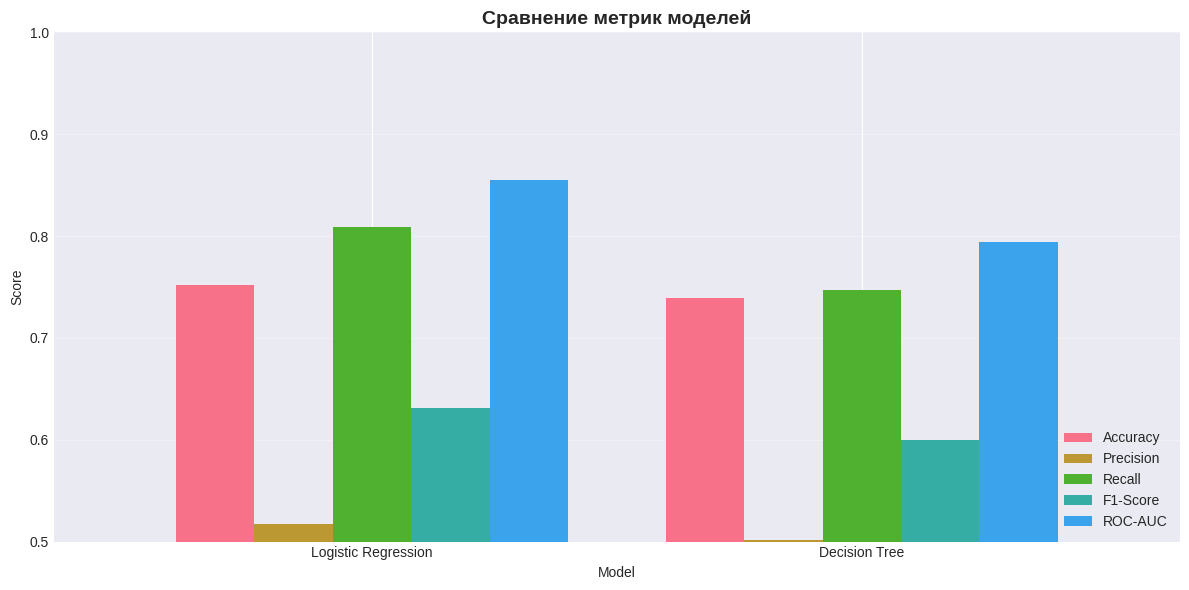


 Лучшая модель: Logistic Regression


In [14]:
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_val, y_pred_logreg),
        accuracy_score(y_val, y_pred_tree)
    ],
    'Precision': [
        precision_score(y_val, y_pred_logreg),
        precision_score(y_val, y_pred_tree)
    ],
    'Recall': [
        recall_score(y_val, y_pred_logreg),
        recall_score(y_val, y_pred_tree)
    ],
    'F1-Score': [
        f1_score(y_val, y_pred_logreg),
        f1_score(y_val, y_pred_tree)
    ],
    'ROC-AUC': [
        roc_auc_score(y_val, y_pred_proba_logreg),
        roc_auc_score(y_val, y_pred_proba_tree)
    ]
})

print("=== Сравнение моделей ===")
print(models_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
models_comparison.set_index('Model').plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Сравнение метрик моделей', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.set_ylim([0.5, 1.0])
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

best_model_idx = models_comparison['ROC-AUC'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\n Лучшая модель: {best_model_name}")

### Матрица ошибок и отчёт по классам
Строю confusion matrix и `classification_report` для лучшей модели, чтобы увидеть баланс ошибок первого и второго рода.


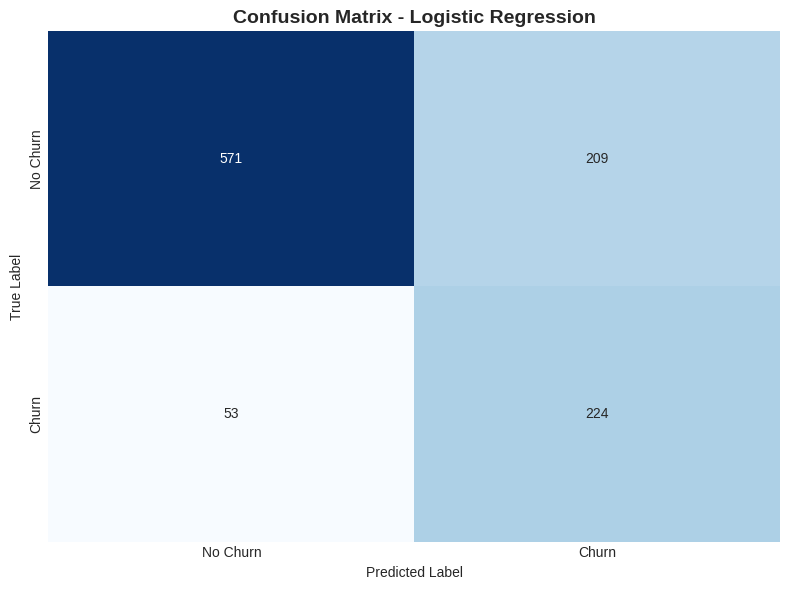


=== Classification Report - Logistic Regression ===
              precision    recall  f1-score   support

    No Churn       0.92      0.73      0.81       780
       Churn       0.52      0.81      0.63       277

    accuracy                           0.75      1057
   macro avg       0.72      0.77      0.72      1057
weighted avg       0.81      0.75      0.77      1057



In [15]:
if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_logreg
    best_model = logreg
else:
    y_pred_best = y_pred_tree
    best_model = tree

cm = confusion_matrix(y_val, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\n=== Classification Report - {best_model_name} ===")
print(classification_report(y_val, y_pred_best, target_names=['No Churn', 'Churn']))

### ROC-кривые
Сравниваю ROC-кривые моделей и их AUC, чтобы визуально оценить устойчивость к изменению порога классификации.


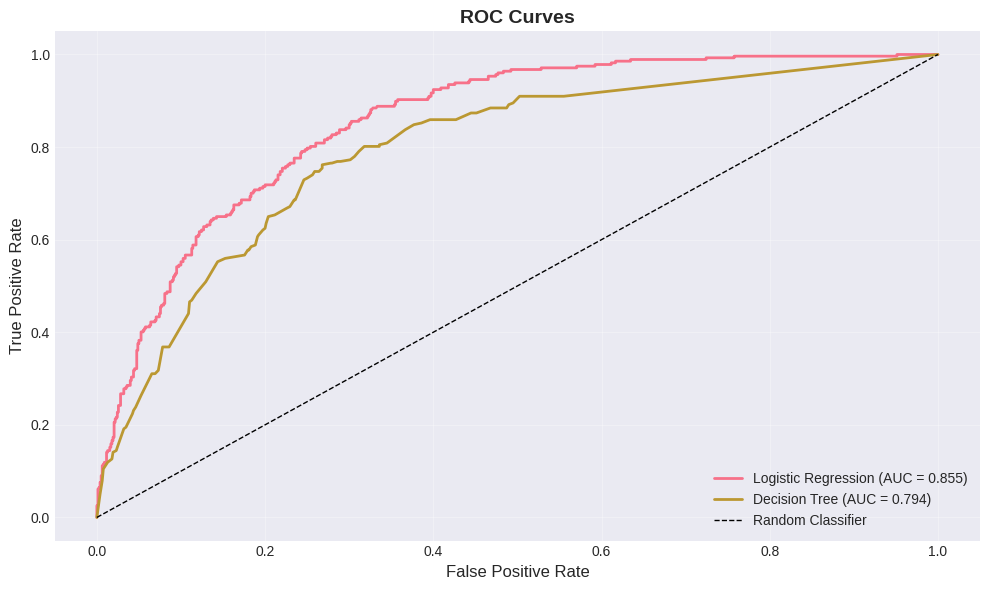

In [16]:
fpr_logreg, tpr_logreg, _ = roc_curve(y_val, y_pred_proba_logreg)
fpr_tree, tpr_tree, _ = roc_curve(y_val, y_pred_proba_tree)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_score(y_val, y_pred_proba_logreg):.3f})', linewidth=2)
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_score(y_val, y_pred_proba_tree):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Важность признаков
Отображаю важности или абсолютные коэффициенты лучшей модели, чтобы понять вклад отдельных признаков в предсказание оттока.


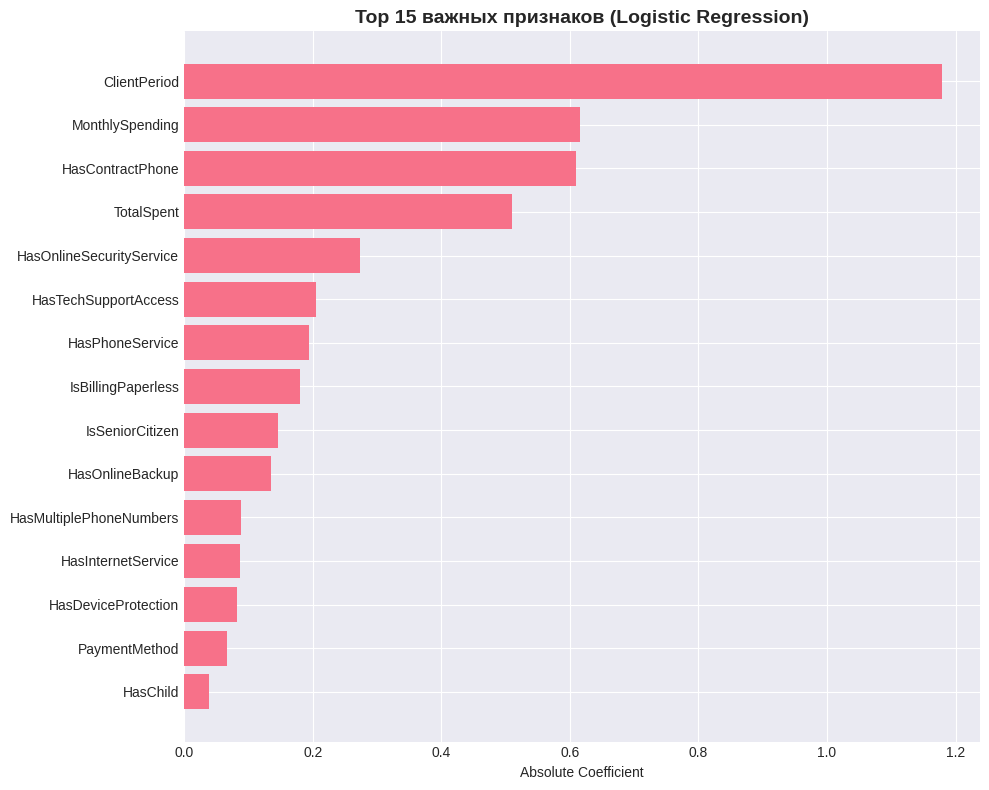

=== Top 10 важных признаков ===
                 Feature  Coefficient
            ClientPeriod     1.178984
         MonthlySpending     0.615770
        HasContractPhone     0.609441
              TotalSpent     0.510596
HasOnlineSecurityService     0.272964
    HasTechSupportAccess     0.204414
         HasPhoneService     0.194799
      IsBillingPaperless     0.179879
         IsSeniorCitizen     0.145876
         HasOnlineBackup     0.134611


In [17]:
if isinstance(best_model, DecisionTreeClassifier):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': tree.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
    plt.xlabel('Importance')
    plt.title('Top 15 важных признаков (Decision Tree)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("=== Top 10 важных признаков ===")
    print(feature_importance.head(10).to_string(index=False))
else:
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': np.abs(logreg.coef_[0])
    }).sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Coefficient'][:15])
    plt.xlabel('Absolute Coefficient')
    plt.title('Top 15 важных признаков (Logistic Regression)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("=== Top 10 важных признаков ===")
    print(feature_importance.head(10).to_string(index=False))

<a id="12-predictions--submission"></a>
## 12. Предсказания и сабмишен
Получаю прогнозы на тестовом наборе лучшей моделью, формирую `submission.csv` и проверяю распределение финальных ответов.


In [18]:
if best_model_name == 'Logistic Regression':
    final_predictions = logreg.predict(test_scaled)
else:
    final_predictions = tree.predict(test_processed)

submission = pd.DataFrame({
    'Id': range(len(final_predictions)),
    'Churn': final_predictions
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

print(f"Submission создан с использованием: {best_model_name}")
print(f"Размер: {submission.shape}")
print(f"\nПервые 10 предсказаний:")
print(submission.head(10))
print(f"\nРаспределение предсказаний:")
print(submission['Churn'].value_counts())

Submission создан с использованием: Logistic Regression
Размер: (1761, 2)

Первые 10 предсказаний:
   Id  Churn
0   0      0
1   1      1
2   2      1
3   3      0
4   4      0
5   5      0
6   6      1
7   7      1
8   8      0
9   9      1

Распределение предсказаний:
Churn
0    1061
1     700
Name: count, dtype: int64
